## Overview of the ML Pipeline in Python Jupyter Notebook
Begin by importing the data from S3 bucket

In [1]:
import pandas as pd

df = pd.read_csv('data/insurance.csv')
# df = pd.read_csv('s3://book-datasets/insurance.csv') # If connecting to S3 bucket
df.head()

# Later to write back to CSV:
# df.to_csv('s3://bucket-name/file.csv', index=False)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


  
    
    
    
    
## Exploratory Data Analysis (i.e. Data Understanding Phase)
### Begin with univariate analyses

In [2]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [3]:
df.skew()

age         0.055673
bmi         0.284047
children    0.938380
charges     1.515880
dtype: float64


  
### Continue with bivariate analyses

In [4]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


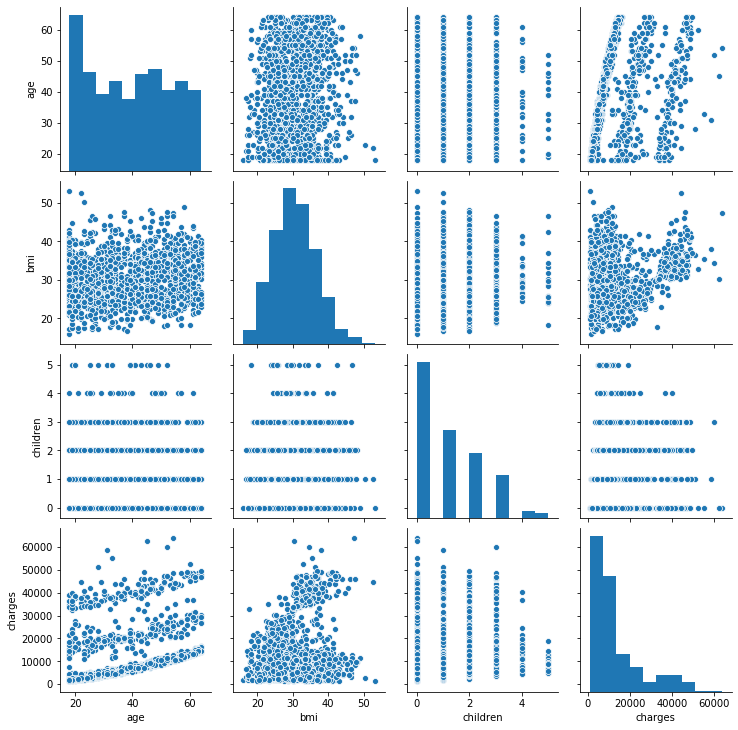

In [5]:
import seaborn as sns
sns.pairplot(df);

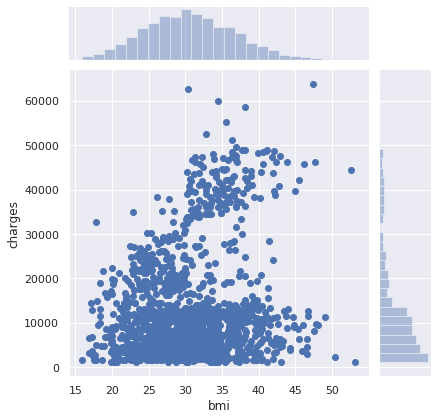

In [6]:
sns.set(color_codes=True)
sns.jointplot(x='bmi', y='charges', data=df);

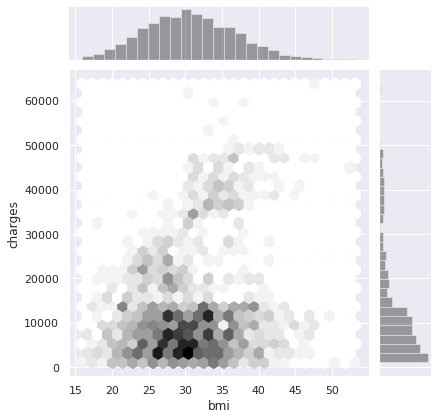

In [7]:
# Hexbin plot
sns.axes_style("white")
sns.jointplot(data=df, x='bmi', y='charges', kind="hex", color="k");

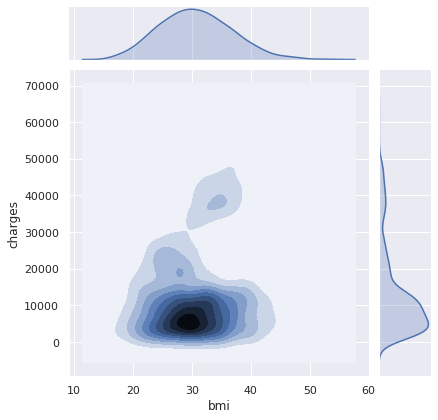

In [8]:
# Kernel density plot
sns.jointplot(data=df, x="bmi", y="charges", kind="kde");

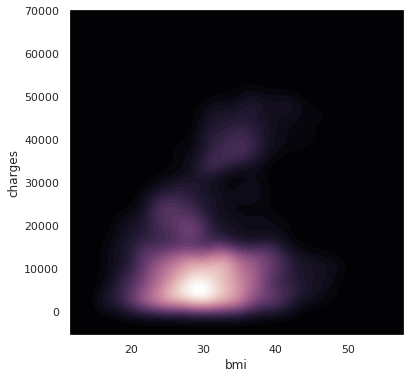

In [9]:
import matplotlib.pyplot as plt

# Deep contour plot
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.bmi, df.charges, cmap=cmap, n_levels=60, shade=True);

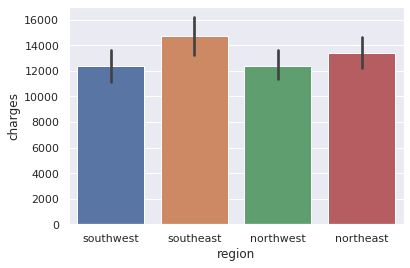

In [10]:
sns.barplot(data=df, x="region", y="charges");

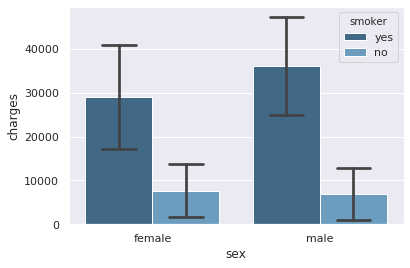

In [11]:
from numpy import median
sns.barplot(data=df, x="sex", y="charges", hue="smoker", estimator=median, ci="sd", capsize=.2, palette="Blues_d");

In [12]:
# Do smokers cost significantly more than non-smokers?

from scipy import stats

smoker_yes = df[df.smoker == 'yes']
smoker_no = df[df.smoker == 'no']
t, p = stats.ttest_ind(smoker_yes.charges, smoker_no.charges)

print('t-Statistic:\t' + str(round(t, 2)))
print('p-value:\t' + str(round(p, 2)))

t-Statistic:	46.66
p-value:	0.0


In [13]:
# Do men cost significantly more than women?

men = df[df.sex == 'male']
women = df[df.sex == 'female']
t, p = stats.ttest_ind(men.charges, women.charges)

print('t-Statistic:\t' + str(round(t, 2)))
print('p-value:\t' + str(round(p, 2)))

t-Statistic:	2.1
p-value:	0.04


In [14]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regression algorithm
from sklearn.ensemble import GradientBoostingRegressor # Import XGBoost algorithm 
from sklearn.model_selection import train_test_split # Import train_test_split function
# for a completelist of available algorithms: https://scikit-learn.org/stable/supervised_learning.html
# Which one should I use?: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [15]:
# Create dummy codes for all features and not the label

for col in df.columns:
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = pd.get_dummies(df, columns=[col], prefix=col)

df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [16]:
# Split dataset in features and target variable

y = df.charges # Label
X = df.drop(columns=['charges']) # Features
X = X.select_dtypes(np.number)
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
X_train.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
744,50,26.41,0,0,1,1,0,0,1,0,0
363,21,26.40,1,1,0,1,0,0,0,0,1
10,25,26.22,0,0,1,1,0,1,0,0,0
970,50,28.16,3,1,0,1,0,0,0,1,0
634,51,39.70,1,0,1,1,0,0,0,0,1


In [18]:
# Create Decision Tree regressor object
clf = DecisionTreeRegressor()

# Train Decision Tree regressor
clf = clf.fit(X_train,y_train)

# Predict the labels for test dataset
y_pred = clf.predict(X_test)

In [19]:
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,})
output_df.head(10)

,Actual,Predicted
559,1646.42970,1263.24900
1087,11353.22760,11945.13270
1020,8798.59300,8457.81800
460,10381.47870,10702.64240
802,2103.08000,1964.78000
298,38746.35510,39983.42595
481,9304.70190,9048.02730
616,11658.11505,11658.37915
763,3070.80870,3558.62025
750,19539.24300,20149.32290


In [20]:
# Import scikit-learn metrics module. See complete list of Classification metrics here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn import metrics
    
print(f'R squared:\t{metrics.r2_score(y_test, y_pred)}')
print(f'MAE:\t\t{metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE:\t\t{metrics.mean_squared_error(y_test, y_pred)**(1/2)}')

R squared:	0.7192346766990366
MAE:		2964.1516434800997
RMSE:		6307.862354958355


In [21]:
# Create XGBoost regressor object
clr = GradientBoostingRegressor()

# Train Decision Tree regression
clr = clf.fit(X_train,y_train)

# Predict the labels for test dataset
y_pred = clr.predict(X_test)

In [22]:
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,})
output_df.head(10)

,Actual,Predicted
559,1646.42970,1263.24900
1087,11353.22760,11842.62375
1020,8798.59300,8457.81800
460,10381.47870,10702.64240
802,2103.08000,1964.78000
298,38746.35510,55135.40209
481,9304.70190,9048.02730
616,11658.11505,11658.37915
763,3070.80870,3558.62025
750,19539.24300,20149.32290


In [23]:
from sklearn import metrics
    
print(f'R squared:\t{metrics.r2_score(y_test, y_pred)}')
print(f'MAE:\t\t{metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE:\t\t{metrics.mean_squared_error(y_test, y_pred)**(1/2)}')

R squared:	0.7184834368316932
MAE:		2987.658830445274
RMSE:		6316.295647265444


In [24]:
import pickle

# Save the model with the highest fit metric
pickle.dump(clr, open('stored_model.sav', 'wb'))  # OPTION 1: pickle

['stored_model.pkl']

In [25]:
# ...some time later

import pickle
import numpy as np

# OPTION 1: Using pickle
# load the model from 'stored_model.sav'
loaded_model = pickle.load(open('stored_model.sav', 'rb'))
print(type(loaded_model))

# for a single prediction, enter a row of data and reshape into numpy array
case = [0.543478, 0.245359, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
print(f'Single prediction {case}: {loaded_model.predict(np.array(case).reshape(1, -1))[0]}\n')

# for a batch prediction, enter a Pandas DataFrame or a Numpy array of arrays
predictions = loaded_model.predict(X_test) 
batch_results = pd.DataFrame({'Actual':y_test, 'Predicted':predictions, 'Diff':(predictions - y_test)})
print(f'MAE:\t{batch_results.Diff.abs().mean()}\n')
batch_results.head(5)

<class 'sklearn.tree._classes.DecisionTreeRegressor'>
Single prediction [0.543478, 0.245359, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]: 16420.49455

MAE:	2987.6588304452744



,Actual,Predicted,Diff
559,1646.4297,1263.24900,-383.18070
1087,11353.2276,11842.62375,489.39615
1020,8798.5930,8457.81800,-340.77500
460,10381.4787,10702.64240,321.16370
802,2103.0800,1964.78000,-138.30000
